# Vehicle Detection Project
The goals / steps of this project are the following:

- Perform a feature extraction (HOG, color transform, binned color, histogram, ...) on a labeled training set of images and train a classifier Linear SVM classifier
- Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
- Run the pipeline on a video stream and create a heat map of recurring detections to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

#### Note about the organisation of the code and this report
This notebook contains python code displaying the differents steps done to identify vehicles in the video stream. The code in this notebook is derived from the code available in standalone python files, with some debug output added to show the intermediate result. I have used the standalone python code to generate the final video. I will indicate in each step of this report where to find the corresponding code in the python files.

## Vehicle vs Non-Vehicle classifier

The first thing to implement for this project is a classifier, capable of discriminate between a vehicle and a non-vehicle image. This classifier will be used later in the pipeline to find the vehicles.

To train this classifier, we have at our disposal the data given by Udacity and coming from the [GTI Vehicle Database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [Kitti Vision Benchmark Suite](http://www.cvlibs.net/datasets/kitti/) and extracted from the project video themselves.

### Manual data exploration
The first step to do is to get an idea of the content of the dataset. We want to know how much example of each class I have, if all the images have the same format (size, number of color channel), if there is an order in the data (if all the white car are first, then all the blue, ..., there must be a randomization done before using the data. If the images are extracted from a video, we must split into training/validation/test using this info, to be sure that we don't have picture very similar in the three sets, because this could lead to unnoticed overfitting)

Let's look the structure of the dataset we are using:

In [1]:
import glob
import os

datapath = './data/'

In [2]:
# lets check the data organisation
veh_dir = glob.glob(datapath + '/vehicles/*')
non_veh_dir = glob.glob(datapath + '/non-vehicles/*')

print('The folders for the vehicles are: {}'.format(', '.join([os.path.basename(x) for x in veh_dir])))
print('The folders for the non vehicles are: {}'.format(', '.join([os.path.basename(x) for x in non_veh_dir])))

The folders for the vehicles are: GTI_Far, GTI_Left, GTI_MiddleClose, GTI_Right, KITTI_extracted
The folders for the non vehicles are: Extras, GTI


We can already see that there is some ordering in the dataset, as they are sorted in different subfolders with meaningfull name. For example, GTI_Left folder contains pictures of car on the left side of the car used to take the picture. When splitting data into training/validation/test sets, we need to do it separately for these folders.

Let's check the number of example in each class:

In [3]:
# lets see if we have a similar number of each classes
vehicles = glob.glob('{}/vehicles/*/*.png'.format(datapath))
non_vehicles = glob.glob('{}/non-vehicles/*/*.png'.format(datapath))

print('The number of vehicle examples is {}'.format(len(vehicles)))
print('The number of non vehicle examples is {}'.format(len(non_vehicles)))

The number of vehicle examples is 8792
The number of non vehicle examples is 8968


The repartition between vehicle and non vehicle is almost balanced, we can work with these examples without removing  any.

Now lets look at the picture themselves. For each subdirectory, I will show a sample of consecutive pictures (consecutives by index number)

All pictures have the same dimensions: (64, 64, 3)


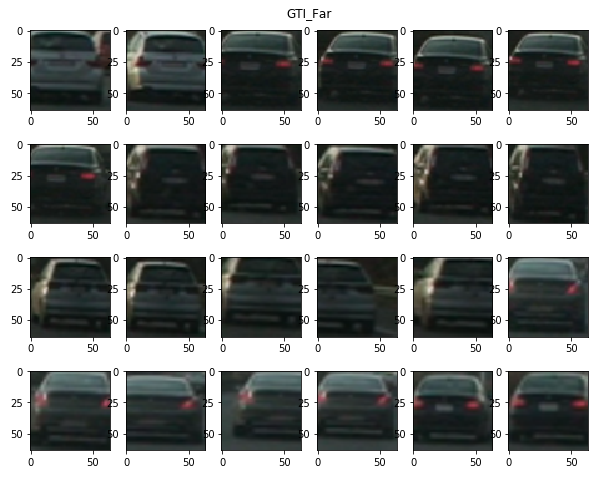

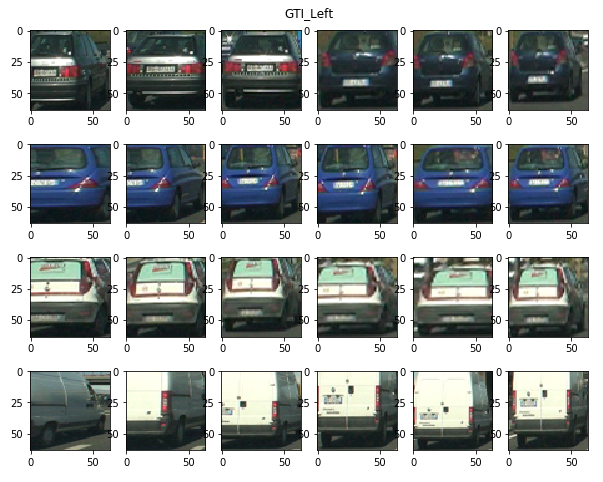

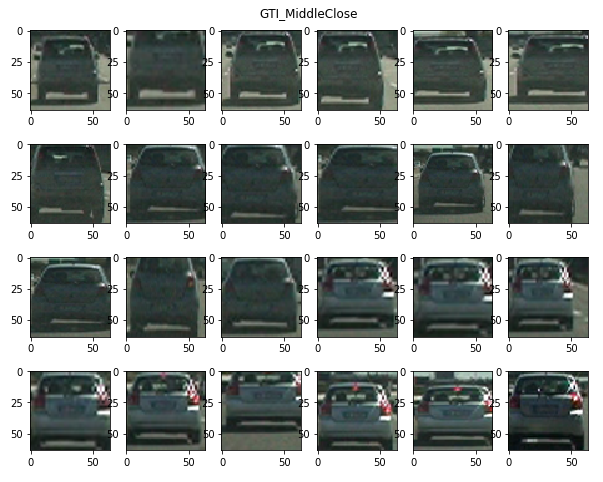

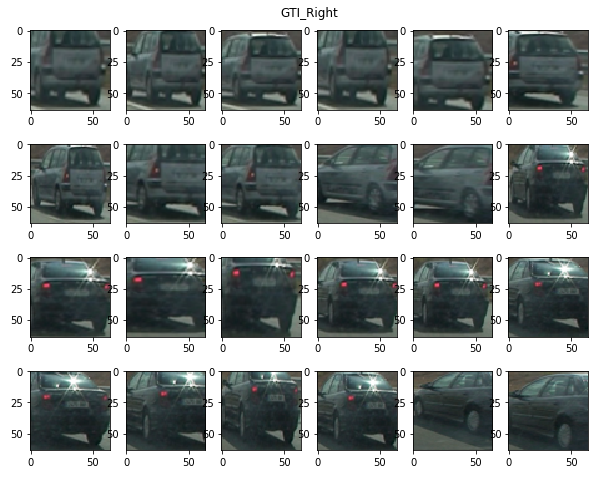

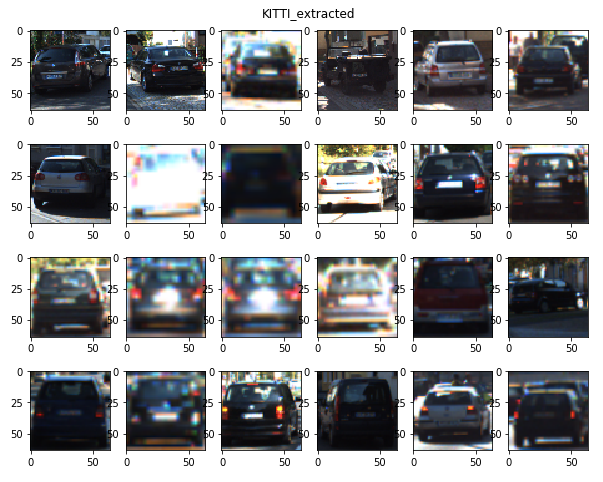

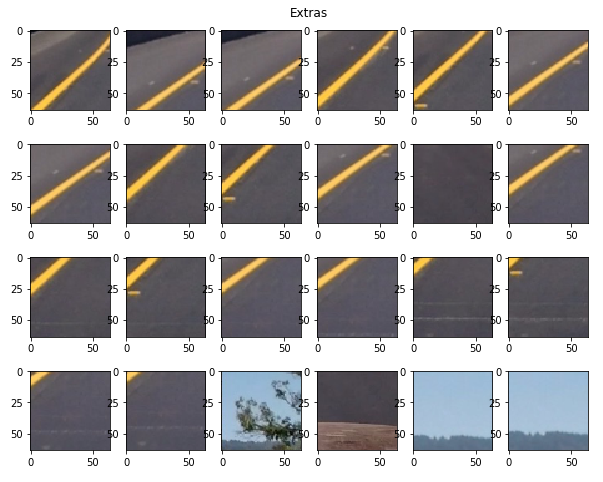

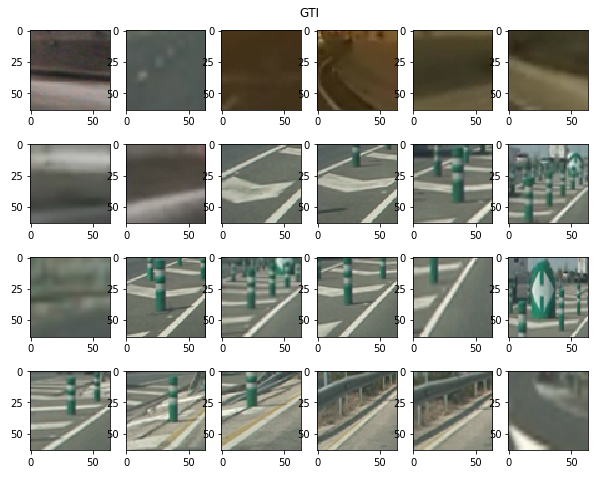

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def display_from_folder(dirname):
    '''Display 24 consecutives images from the given folder
    Return the image shape'''
    images = glob.glob(dirname + '/*.png')
    idx = np.random.randint(len(images)-24)
    
    fig = plt.figure(figsize=(10,8))
    plt.title(os.path.basename(dirname))
    plt.axis('off')

    for i in range(24):
        ax = fig.add_subplot(4,6,i+1)
        img = plt.imread(images[idx+i])
        ax.imshow(img)
        # to check the size
        if i == 0:
            shape = img.shape
        else:
            assert(shape == img.shape)
    return shape

shape = []
for folder in veh_dir:
    shape.append(display_from_folder(folder))
for folder in non_veh_dir:
    shape.append(display_from_folder(folder))

# verify that all are equal
assert(all(x == shape[0] for x in shape))
print("All pictures have the same dimensions: {}".format(shape[0]))

We see that at least for the GTI images, the pictures are taken in sequence. They are coming from a video stream and consecutive images comes are from the same car. This information must be used when splitting the dataset.

We also see on these plots that all the pictures have the same format, 64x64x3.

Let's split the images into train/valid/test sets. I will use a split of 80/10/10 respectively. I will do the split on ordered dataset, separately for all subdirectory, and the join them together and randomize them.

The code handling the reading, splitting in several dataset, and shuffling them can be found in the file `classifier.py`, function `read_images()`

### Features extraction

To train (and use) the classifier, we cannot directly use the images themselves, this would not generalize well. We need to extract features from them. As suggested in the Udacity lesson, I will combine [Histogram of oriented gradient](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) and [Spatial binning](https://en.wikipedia.org/wiki/Data_binning) methods. The code used for these in my final pipeline can be found in the `feature_extraction.py` file, functions `hog_features()` and `bin_spatial()`. The combination of this two features can be found in the same file, the function is `generate_features()` (it also allows you to create a color histogram, but I haven't kept this method in the end, as it was not really improving the classifier accuracy).

#### Spatial binning
The spatial binning method consist of clustering together groups of pixels of the original image. This is simply done by reducing the size of a picture, creating a low resolution of the image. As you can see below, an human eye is still capable of identifying a vehicle from a non-vehicle on this kind of low resolution image.

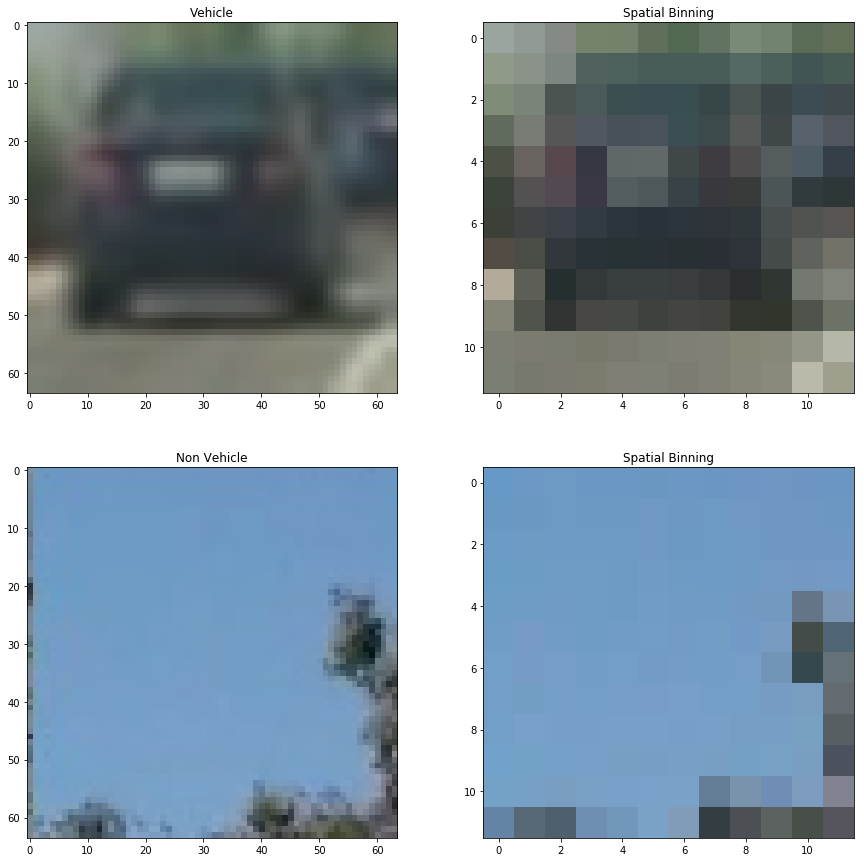

In [5]:
import cv2

def bin_spatial_as_picture(img, size=(12, 12)):        
    return cv2.resize(img, size)

vehicle = glob.glob('data/vehicles/*/*.png')
non_vehicle = glob.glob('data/non-vehicles/*/*.png')
img_car = plt.imread(vehicle[0])
img_non_car = plt.imread(non_vehicle[0])

f, axarr = plt.subplots(2, 2,figsize=(15,15))
axarr[0, 0].imshow(img_car)
axarr[0, 0].set_title('Vehicle')
axarr[0, 1].imshow(bin_spatial_as_picture(img_car))
axarr[0, 1].set_title('Spatial Binning')

axarr[1, 0].imshow(img_non_car)
axarr[1, 0].set_title('Non Vehicle')
axarr[1, 1].imshow(bin_spatial_as_picture(img_non_car))
axarr[1, 1].set_title('Spatial Binning')

#### Histogram of oriented gradients
The histogram of oriented gradients is a method relying on the gradient of the picture. This method use both the gradient intensity and direction of the image. The gradient is computed for the full image, and then the obtained values are grouped in cells of pixels. In each of theses cells, an histogram of the orientation and intensity of gradients is computed, and this histogram is the feature.

This feature is not as easy to interpret for the human eye as the spatial binning feature, but it has a good performance for the SVM classifier in this project.

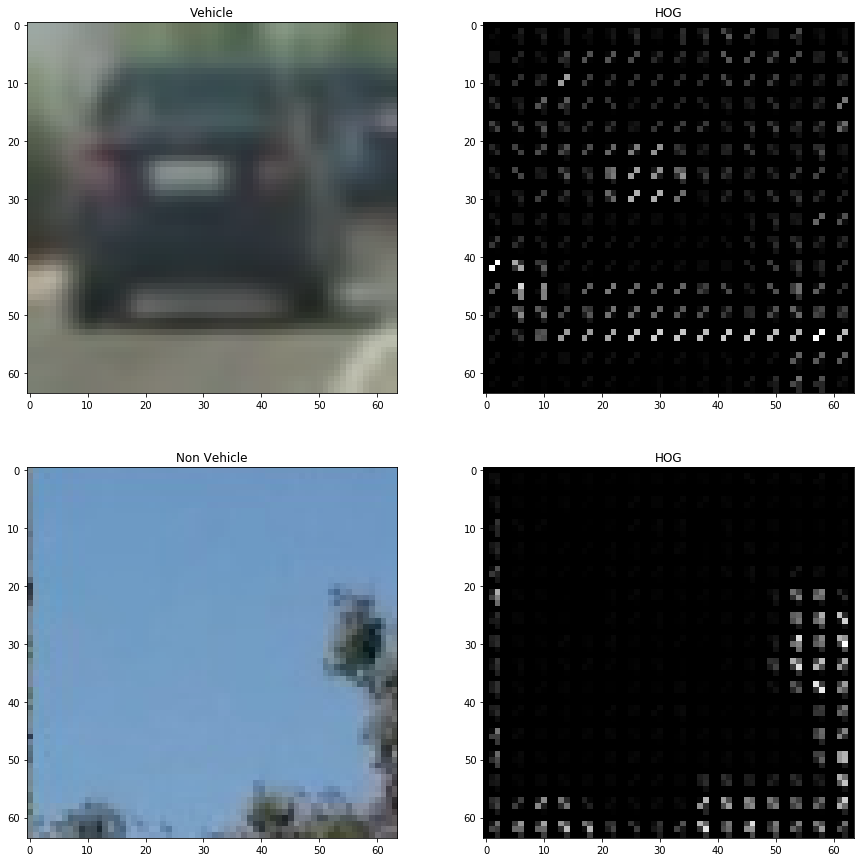

In [6]:
from skimage.feature import hog

car_gray = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY)
non_car_gray = cv2.cvtColor(img_non_car, cv2.COLOR_RGB2GRAY)

features, hog_car = hog(car_gray, orientations=9, pixels_per_cell=(4,4),
                       cells_per_block=(1,1), transform_sqrt=False, 
                       visualise=True, feature_vector=False)
features, hog_non_car = hog(non_car_gray, orientations=9, pixels_per_cell=(4,4),
                            cells_per_block=(1,1), transform_sqrt=False, 
                            visualise=True, feature_vector=False)

f, axarr = plt.subplots(2, 2,figsize=(15,15))
axarr[0, 0].imshow(img_car)
axarr[0, 0].set_title('Vehicle')
axarr[0, 1].imshow(hog_car, cmap='gray')
axarr[0, 1].set_title('HOG')

axarr[1, 0].imshow(img_non_car)
axarr[1, 0].set_title('Non Vehicle')
axarr[1, 1].imshow(hog_non_car, cmap='gray')
axarr[1, 1].set_title('HOG')

#### Final feature
For my project, I have used at the end a combination of spatial binning with a size of (16,16) and a HOG with (8,8) cells, 24 orientation buckets and (1,1) block per cell.

### SVM classifier

Once the features have been generated, it's time to select and train a classifier. The full code for the classifier can be found in `classifier.py`, but here are the importants choices and the computed results.

Before feeding the features to the classifier, it's important to normalize them, to avoid bad numerical conditioning. It could be done by using separately a feature scaler and then a classifier, but it's even easier to use if we put them together in a sklearn pipeline. My classifier is then defined as follow:

In [7]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(StandardScaler(),
                           LinearSVC())

The `classifier.py` file also contains the final feature definition:

In [8]:
features_definition = {
    "spatial_bin": (16,16),
    "hog": {"orientations": 24, "px_per_cell": 8, "cell_per_block": 1, "channel": "ALL", "color_space": "HLS"},
    "classifier_size": (64,64),
    }

The rest of the code in the classifier is the classical "read the data", "get features", "train the classifier", "check the accuracy", "save the classifier and feature definition". Here is the result of the exectution:

    $ time python classifier.py 
    Training Accuracy of SVC =  1.0
    Validation Accuracy of SVC =  0.9961
    
    real    1m46,528s
    user    1m41,653s
    sys     0m2,603s

The accuracy is really high, and the time to train it is reasonable. Most of the time here is actually passed in reading the images files and extracting the features, the training of the classifier itself takes seconds, and predictions once the features are extracted takes a few milliseconds for 1000 instances. The classifier will not be the part to look at for optimisation in term of time later, as long as I stuck with a LinearSVM.

## Single image pipeline

### Sliding window

The idea of the sliding windows is to scan horizontally and vertically the image where we want to find vehicles with smaller sliding windows of various size. As the top of the image shows the sky and the bottom shows a part of the hood of the car, we don't need to look there. We need different windows size as when a car is closer, it will appears bigger. Smaller car size are further, and will be further up in the image. We can use this info to restric even more the region of interest for each sliding window size.

An example of such sliding windows is shown in the image below (it's much less dense in term of windows that the final sliding that I have used, it's there to show the concept)

The final pattern that I have used only has windows of size 64 and 96 pixels (square shaped), but with a big overlapping. (smaller windows size were giving me more false positives, and larger size weren't giving much more information)

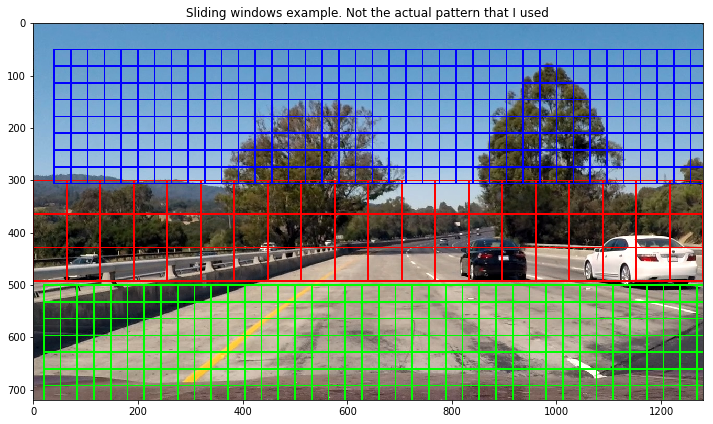

In [9]:
img = plt.imread('test_images/test1.jpg')

def get_bboxes(size, overlap, x_range, y_range):
    # just for using cv2.rectangle, I don't need to remove box with parts outside the picture
    # to keep this code easier
    bboxes = []
    for x in range(*x_range, int(size*overlap)):
        for y in range(*y_range, int(size*overlap)):
            bboxes.append(((x,y),(x+size,y+size)))
    return bboxes

for pts1,pts2 in get_bboxes(128, .5, (0,1280), (300,400)):
    cv2.rectangle(img, pts1, pts2, (255,0,0), 2)
    
for pts1,pts2 in get_bboxes(64, .5, (20,1280), (500, 720)):
    cv2.rectangle(img, pts1, pts2, (0,255,0), 2)
    
for pts1,pts2 in get_bboxes(32, 1, (40,1280), (50,300)):
    cv2.rectangle(img, pts1, pts2, (0,0,255), 2)
    
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.title("Sliding windows example. Not the actual pattern that I used")
    

A naive implementation could be done as follow: Take each corners computed of the sliding windows, extract the picture inside the box, and feed it to the get_feature function used for the SVC training. Something like the code below:

In [10]:
# to show the structure of sliding windows definitions that I used, actual values not important here
win_defs = [
        {"size": (64, 64), "overlap": (1/8, 1/8), "x_range": (0, 1024), "y_range": (400,528)},
        {"size": (96, 96), "overlap": (1/8, 1/8), "x_range": (0, 1024), "y_range": (400,720)},
    ]

def get_features_sliding_naive(img, win_def, get_feature, feature_definition):
    # get_feature() would be the function used to extract features in the classifier part, from a 64x64 window
    
    features = []
    bboxes = []
    
    # for all windows size
    for win_def in win_defs:
        size = win_def["size"]
        over = win_def["overlap"]
        x_lim = win_def["x_range"]
        y_lim = win_def["y_range"]
        
        # slide the windows on x and y
        for x in range(x_lim[0], x_lim[1]-size[0], int(size[0]*over[0])):
            for y in range(y_lim[0], y_lim[1]-size[1], int(size[1]*over[1])):
                
                # current windows corners
                bboxes.append((x,y),(x+size[0], y+size[1]))
                
                # extract the windows from image
                current_win = img[x:x+size[0], y:y+size[1],:]
                # resize it to 64x64
                current_win_64 = cv2.resize(current_win, (64,64))
                
                # use original function to compute the feature
                features.append(get_features(current_win_64, feature_definition))
                
    return features, bboxes

### Feature extraction optimization

This example of code gives the correct result (I hope, as I haven't run this exact version, it's only for the report, but I had one working at some point when developping ;-) ), but is extremely innefficient, because it will compute for each windows the full HOG, and do a resize for the spatial binning. It doesn't takes advantage of the structure of the data that we want to analyze.

To make this code faster, we can notice that due to the overlapping, we can reuse data computed from previous windows. For example, if we have an overlapping of 7/8 (that is the windows slide by 1/8 of it's size. I have used the reverse notation in my code, "overlap = 1/8 is moving by 12.5%, sorry), we can reuse 87.5% of the HOG gradient used in the previous windows. And the same goes when moving horizontally and vertically.

It is possible to use this information to make the code mode efficient. And the same kind of idea goes for the spatial binning (it's even easier, as spatial binning is only a change in the picture resolution, just compute the good scale, et voila, you have the values. You juste need to slice them correctly) (The HOG feature part is not much more difficult, as the `skimage` module has already everything in place, you only need to understand the function call.

The full code of the feature extraction with sliding windows is available in the `feature_extraction.py` file, in the `generate_features_sliding(img, features_definition, windows_definitions)` function.

I haven't kept the naive implementation that I had at the beginning to benchmark it now, but the speed improvement between the naive implementation and an optimized one were large (more than 5 times faster, I think. And I wasn't using a 7/8 overlap at that time) 

To reduce the number of false positive in single picture mode, I don't consider as positive pixels where only one sliding windows sees a car. In the pictures below, the sliding windows detecting a car are showed in green, and positive car detection (--> at least two windows) are shown in red.

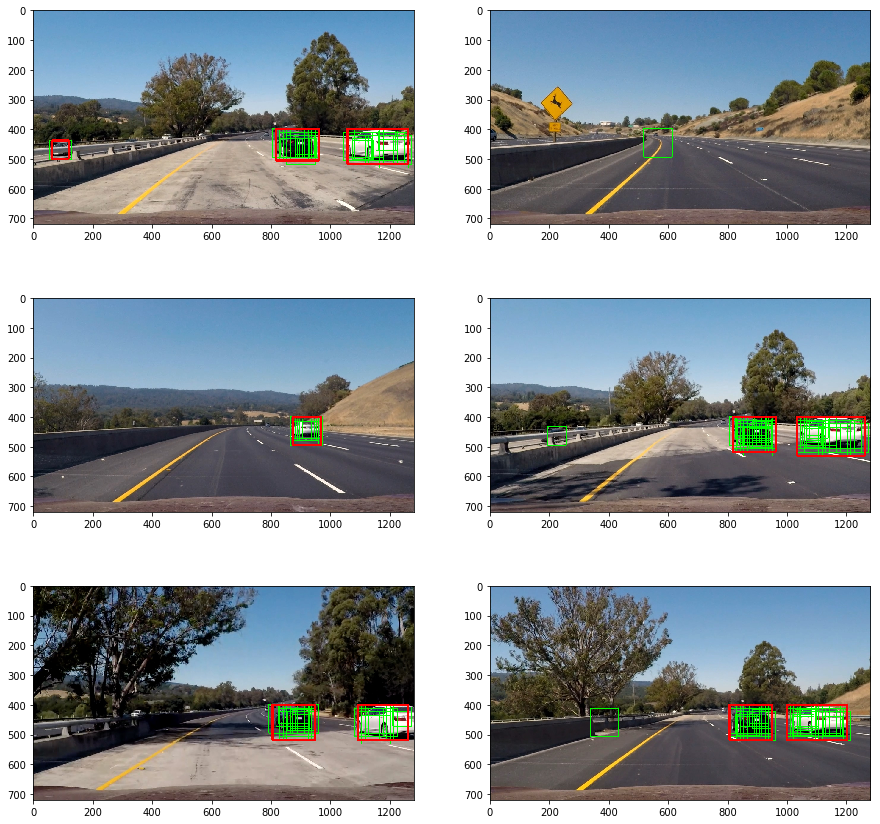

In [11]:
from image_pipeline import find_and_draw
import pickle

feature_def = pickle.load( open( "feature_def.p", "rb" ) )
clf = pickle.load( open( "classifier.p", "rb" ) )

window_definitions = [
    {"size": (64, 64), "overlap": (1/8, 1/8), "x_range": (None, None), "y_range": (400,529)},
    {"size": (96, 96), "overlap": (1/8, 1/8), "x_range": (None, None), "y_range": (400,None)},
]

f, axarr = plt.subplots(3, 2,figsize=(15,15))
for fname,ax in zip(glob.glob('test_images/*jpg'), axarr.ravel()):
    img = plt.imread(fname)
    res = find_and_draw(img, feature_def, window_definitions, clf)
    ax.imshow(res)

As you can see on the two pictures, the two cars seem well detected. There would be a few false positives visible (green boxes without red around them), if I wasn't looking for at least two detections.

The full image pipeline is contained in the `image_pipeline.py`.

## Video pipeline

A concept similar to the image pipeline is applied for the video pipeline. But in addition to detecting two overlapping windows on a single frame, the detection of one single window in one frame would be enough to consider a pixel as inside a car, at the condition that the algorithm decided that there was a car there in the previous frame. This is done in the following manner: (example code, the functional code is available in the `video_pipeline.py` file.

### Heatmap

In [12]:
# conceptually, it works like this
from scipy.ndimage.measurements import label

class VideoPipeline:
    def __init__(self):
        self.heat_map = np.zeros(img.shape[:2], np.uint8)
        self.threshold = 2
        # ...

    def handle_frame(self,img):
        # reduce the "temperature"
        heat_map[heat_map>0] -= 1
        
        # get single frame detection
        features, bboxes = generate_features_sliding(img, self.feature_def, self.window_definitions)
        # increase the temperature in detected zones
        for pts1,pts2 in bboxes[pred]:
            self.heatmap[pts1[1]:pts2[1], pts1[0]:pts2[0]] += 1
        
        # discard everything below threshold
        self.heatmap[self.heatmap<self.threshold] = 0
        # limit the max temperature
        self.heatmap[self.heatmap>self.threshold+2] = self.threshold+2
        
        # identify connected cars and draw boxes
        labels = label(self.heatmap)
        return draw_labeled_bboxes(img, labels)
        
        
    

### Video generation
The video generation is done with MoviePy in the following way. (Note: this does only the small video example. For the full project_video.mp4, see `video_pipeline.py` main function. But it's the same thing, with different file names)

In [13]:
from video_pipeline import VideoPipeline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

feature_def = pickle.load( open( "feature_def.p", "rb" ) )
clf = pickle.load( open( "classifier.p", "rb" ) )

window_definitions = [
    {"size": (64, 64), "overlap": (1/8, 1/8), "x_range": (None, None), "y_range": (400,529)},
    {"size": (96, 96), "overlap": (1/8, 1/8), "x_range": (None, None), "y_range": (400,None)},
]
    
pipeline = VideoPipeline(clf, feature_def, window_definitions)
output = 'out.mp4'
clip = VideoFileClip('test_video.mp4', audio=None)
out_clip = clip.fl_image(pipeline.update)
out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


 97%|█████████▋| 38/39 [00:33<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 



In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

Here is the full project video on Youtube

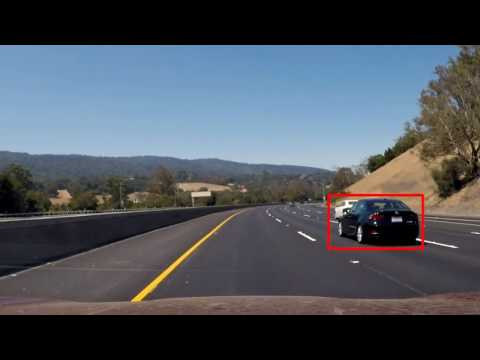

In [15]:
from IPython.display import YouTubeVideo
YouTubeVideo('xNwoNi5qhik')

## Conclusion

My current pipeline implementation does a good job, but not a perfect one. There are still some false positive, and the cars bounding box could be slightly better, but they are identified.

The current performance in term of speed of my pipeline is between 1 and 2 images per second on my laptop (not recent, he's a few years old. And only if I don't do heavy other stuff on the side) which is very far from realtime, I think that there is a lot of room for improvement. One possibility would be to have less sliding windows to cover, or optimise the feature extraction even more, if possible.

One of the problems that I had was that the left yellow line was often detected as a positive. I've managed to reduce the false positive there (and in a few other places) by adding the threshold filtering only multiple detection in one place. Another way to reduce the false positives could be to have a better classifier. This could comes from more data (I could use the udacity bigger dataset, and do some hard negative mining for the negative class) or from a different classifier, or a different feature selection. I have tried to use a non linear SVM (SVC with rbf kernel) but the time penalty was prohibitive. I haven't fully explored all the possible feature selections possible, as I have found the current parameters that gives this passable result.

##### Note: Running the python files
If you want to run the python files, you need to have the positive and negative examples in subfolders of `./data/vehicle/[something]/` and the same with `non-vehicle`.

You need to run first `classifier.py` to create the classifier and feature definition file, and then either `image_pipeline` or `video_pipeline`.